<a href="https://colab.research.google.com/github/farshidehkordi/Homework2_AI/blob/main/TP2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os


# List files in the current directory
print(os.listdir())

['.config', 'sample_data']


In [4]:
!unzip ./codeTP2.zip
# extract files


Archive:  ./codeTP2.zip
   creating: code/data-q2/
  inflating: code/data-q2/test.txt   
  inflating: code/data-q2/train.txt  
  inflating: code/q2-RNN.py          
  inflating: code/question1.py       


In [3]:
!pip install poutyne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.5/213.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 26.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-many

Initial architecture with the bidirectional WordClassifier class

In [7]:
import logging
import random
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from poutyne.framework import Model

# Define embedding_size and hidden_size
embedding_size = 10
hidden_size = 10


# bidirectional
class WordClassifier(nn.Module):
    def __init__(self, vocab, embedding_size, hidden_size, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(len(vocab), embedding_size, padding_idx=0)
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True, bidirectional=True)  # Bidirectional RNN
        self.mapping_layer = nn.Linear(hidden_size * 2, num_classes)  # Multiply hidden size by 2 for bidirectional RNN

    def forward(self, inputs):
        # Inputs: (batch_size, seq_len)
        embedded = self.embedding(inputs)  # Shape: (batch_size, seq_len, embedding_size)

        output, _ = self.rnn(embedded)  # Shape: (batch_size, seq_len, hidden_size * 2) because it's bidirectional

        # Take the last output of the sequence
        last_output = output[:, -1, :]

        logits = self.mapping_layer(last_output)  # Shape: (batch_size, num_classes)
        return logits



class WordClassifierHandlingPadding(WordClassifier):
    def __init__(self, vocab, embedding_size, hidden_size, num_classes):
        super().__init__(vocab, embedding_size, hidden_size, num_classes)

    def forward(self, inputs):
        # Inputs: (batch_size, seq_len)
        embedded = self.embedding(inputs)  # Shape: (batch_size, seq_len, embedding_size)
        output, _ = self.rnn(embedded)     # Shape: (batch_size, seq_len, hidden_size)
        last_output = output[:, -1, :]     # Take the last output of the sequence
        logits = self.fc(last_output)      # Shape: (batch_size, num_classes)
        return logits



def vectorize_dataset(dataset, char_to_idx, class_to_idx):
    vectorized_dataset = list()
    for word, lang in dataset:
        label = class_to_idx[lang]
        vectorized_word = list()
        for char in word:
            vectorized_word.append(char_to_idx.get(char, 1))  # Get the char index otherwise set to unknown char
        vectorized_dataset.append((vectorized_word, label))
    return vectorized_dataset


def load_data(filename):
    examples = list()
    with open(filename) as fhandle:
        for line in fhandle:
            examples.append(line[:-1].split())
    return examples


def create_indexes(examples):
    char_to_idx = {"<pad>": 0, "<unk>": 1}
    class_to_idx = {}

    for word, lang in examples:
        if lang not in class_to_idx:
            class_to_idx[lang] = len(class_to_idx)
        for char in word:
            if char not in char_to_idx:
                char_to_idx[char] = len(char_to_idx)
    return char_to_idx, class_to_idx


def make_max_padded_dataset(dataset):
    max_length = max([len(w) for w, l in dataset])
    tensor_dataset = torch.zeros((len(dataset), max_length), dtype=torch.long)
    labels = list()
    for i, (word, label) in enumerate(dataset):
        tensor_dataset[i, :len(word)] = torch.LongTensor(word)
        labels.append(label)
    return tensor_dataset, torch.LongTensor(labels)

def collate_examples(samples):
    # Get the length of the longest sequence in the batch
    max_len = max(len(word) for word, _ in samples)

    # Initialize lists to store padded sequences and labels
    padded_sequences = []
    labels = []

    # Pad each sequence to have the same length as the longest sequence in the batch
    for word, label in samples:
        # Convert the tensor to a Python list
        word_list = word.tolist()

        # Pad the sequence with the padding token ("<pad>") to match the maximum length
        padded_sequence = torch.tensor(word_list + [0] * (max_len - len(word_list)), dtype=torch.long)
        padded_sequences.append(padded_sequence)
        labels.append(label)

    # Convert the lists to PyTorch tensors
    padded_sequences_tensor = torch.stack(padded_sequences)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return padded_sequences_tensor, labels_tensor





def main():
    batch_size = 128
    training_set = load_data("./code/data-q2/train.txt")
    test_set = load_data("./code/data-q2/test.txt")


    char_to_idx, class_to_idx = create_indexes(training_set)

    vectorized_train = vectorize_dataset(training_set, char_to_idx, class_to_idx)
    vectorized_test = vectorize_dataset(test_set, char_to_idx, class_to_idx)

    X_train, y_train = make_max_padded_dataset(vectorized_train)
    X_test, y_test = make_max_padded_dataset(vectorized_test)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # 1: Create a simple network that takes inputs of fixed length (max length)
    network = WordClassifier(char_to_idx, 10, 10, len(class_to_idx))
    model = Model(network, 'sgd', 'cross_entropy', batch_metrics=['accuracy'])
    model.fit_generator(train_loader, epochs=5)
    loss, acc = model.evaluate_generator(test_loader)
    logging.info("1 - Loss: {}\tAcc:{}".format(loss, acc))



if __name__ == "__main__":
    logging.getLogger().setLevel(logging.INFO)
    np.random.seed(42)
    random.seed(42)
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    main()



Epoch: 1/5 Train steps: 1696 20.32s loss: 2.294531 acc: 12.554144                                
Epoch: 2/5 Train steps: 1696 20.40s loss: 2.290366 acc: 13.035685                                
Epoch: 3/5 Train steps: 1696 20.02s loss: 2.290358 acc: 13.035685                                
Epoch: 4/5 Train steps: 1696 24.37s loss: 2.290369 acc: 13.035685                                
Epoch: 5/5 Train steps: 1696 35.12s loss: 2.290363 acc: 13.035685                                
Test steps: 424 1.60s test_loss: 2.291355 test_acc: 13.044200                                 


INFO:root:1 - Loss: 2.2913547406727623	Acc:13.044199506378764


In [8]:
import logging
import random

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
import numpy as np
from poutyne.framework import Model


class WordClassifier(nn.Module):
    def __init__(self, vocab, embedding_size, hidden_size, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(len(vocab), embedding_size, padding_idx=0)
        self.rnn = nn.RNN(input_size=embedding_size, hidden_size=hidden_size, num_layers=5, batch_first=True)
        self.mapping_layer = nn.Linear(hidden_size, num_classes)

    def forward(self, inputs):
        embedded = self.embedding(inputs)  # Shape: (batch_size, seq_len, embedding_size)
        output, _ = self.rnn(embedded)
        last_output = output[:, -1, :]  # Take the last output of each sequence
        logits = self.mapping_layer(last_output)  # Shape: (batch_size, num_classes)
        return logits



class WordClassifierHandlingPadding(WordClassifier):
    def __init__(self, vocab, embedding_size, hidden_size, num_classes):
        super().__init__(vocab, embedding_size, hidden_size, num_classes)

    def forward(self, inputs):
        # TODO: Gestion des exemples a longueur variable
        # Servez-vous de la fonction pack_padded_sequence
        pass


def vectorize_dataset(dataset, char_to_idx, class_to_idx):
    vectorized_dataset = list()
    for word, lang in dataset:
        label = class_to_idx[lang]
        vectorized_word = list()
        for char in word:
            vectorized_word.append(char_to_idx.get(char, 1))  # Get the char index otherwise set to unknown char
        vectorized_dataset.append((vectorized_word, label))
    return vectorized_dataset


def load_data(filename):
    examples = list()
    with open(filename) as fhandle:
        for line in fhandle:
            examples.append(line[:-1].split())
    return examples


def create_indexes(examples):
    char_to_idx = {"<pad>": 0, "<unk>": 1}
    class_to_idx = {}

    for word, lang in examples:
        if lang not in class_to_idx:
            class_to_idx[lang] = len(class_to_idx)
        for char in word:
            if char not in char_to_idx:
                char_to_idx[char] = len(char_to_idx)
    return char_to_idx, class_to_idx


def make_max_padded_dataset(dataset):
    max_length = max([len(w) for w, l in dataset])
    tensor_dataset = torch.zeros((len(dataset), max_length), dtype=torch.long)
    labels = list()
    for i, (word, label) in enumerate(dataset):
        tensor_dataset[i, :len(word)] = torch.LongTensor(word)
        labels.append(label)
    return tensor_dataset, torch.LongTensor(labels)


def collate_examples(samples):
    # TODO: Cette fonction devrait faire du "padding on batch"
    # i.e. utiliser la longueur de la séquence la plus longue
    # de la batch et non pas du jeu de données complet.
    pass


def main():
    batch_size = 128
    training_set = load_data("./code/data-q2/train.txt")
    test_set = load_data("./code/data-q2/test.txt")

    char_to_idx, class_to_idx = create_indexes(training_set)

    vectorized_train = vectorize_dataset(training_set, char_to_idx, class_to_idx)
    vectorized_test = vectorize_dataset(test_set, char_to_idx, class_to_idx)

    X_train, y_train = make_max_padded_dataset(vectorized_train)
    X_test, y_test = make_max_padded_dataset(vectorized_test)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # 1: Créez un réseau simple qui prend en entré des exemples de longueur fixes (max length)
    network = WordClassifier(char_to_idx, 10, 10, len(class_to_idx))
    model = Model(network, 'sgd', 'cross_entropy', batch_metrics=['accuracy'])
    model.fit_generator(train_loader, epochs=5)
    loss, acc = model.evaluate_generator(test_loader)
    logging.info("1 - Loss: {}\tAcc:{}".format(loss, acc))

    # 2: Faites en sorte que le padding soit fait "on batch"
    # Le tout devrait se passer dans la fonction collate_examples
    train_loader = DataLoader(vectorized_train, batch_size=128, shuffle=True, collate_fn=collate_examples)
    test_loader = DataLoader(vectorized_test, batch_size=128, collate_fn=collate_examples)
    model = Model(network, 'sgd', 'cross_entropy', batch_metrics=['accuracy'])
    model.fit_generator(train_loader, epochs=5)
    loss, acc = model.evaluate_generator(test_loader)
    logging.info("2 - Loss: {}\tAcc:{}".format(loss, acc))

    # 3: Créez une architecture qui gère convenablement des séquences de longueur différentes
    network = WordClassifierHandlingPadding(char_to_idx, 10, 10, len(class_to_idx))
    model = Model(network, 'sgd', 'cross_entropy', batch_metrics=['accuracy'])
    model.fit_generator(train_loader, epochs=5)
    loss, acc = model.evaluate_generator(test_loader)
    logging.info("3 - Loss: {}\tAcc:{}".format(loss, acc))



if __name__ == "__main__":
    logging.getLogger().setLevel(logging.INFO)
    np.random.seed(42)
    random.seed(42)
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    main()


Epoch: 1/5 Train steps: 1696 43.79s loss: 2.293860 acc: 12.796067                                
Epoch: 2/5 Train steps: 1696 41.17s loss: 2.290389 acc: 13.035224                                
Epoch: 3/5 Train steps: 1696 48.36s loss: 2.290400 acc: 13.035224                                
Epoch: 4/5 Train steps: 1696 40.54s loss: 2.290409 acc: 13.035224                                
Epoch: 5/5 Train steps: 1696 43.97s loss: 2.290370 acc: 13.035224                                
Test steps: 424 2.58s test_loss: 2.291327 test_acc: 13.042356                                


INFO:root:1 - Loss: 2.291327490590195	Acc:13.042356324309239


TypeError: cannot unpack non-iterable NoneType object

Adding the collate_examples function

In [5]:
import logging
import random
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from poutyne.framework import Model
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
from typing import Dict


# Define embedding_size and hidden_size
embedding_size = 10
hidden_size = 10


# Bidirectional RNN
class WordClassifier(nn.Module):
    def __init__(self, vocab, embedding_size, hidden_size, num_classes, dropout_prob=0.5):
        super().__init__()
        self.embedding = nn.Embedding(len(vocab), embedding_size, padding_idx=0)
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_prob)  # Dropout layer
        self.mapping_layer = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, inputs):
        embedded = self.embedding(inputs)
        output, _ = self.rnn(embedded)
        last_output = output[:, -1, :]
        last_output = self.dropout(last_output)  # Apply dropout
        logits = self.mapping_layer(last_output)
        return logits


def vectorize_dataset(dataset, char_to_idx, class_to_idx):
    vectorized_dataset = list()
    for word, lang in dataset:
        label = class_to_idx[lang]
        vectorized_word = [char_to_idx.get(char, char_to_idx["<unk>"]) for char in word]
        vectorized_dataset.append((vectorized_word, label))
    return vectorized_dataset


def collate_examples(samples, padding_value=0):
    max_len = max(len(word) for word, _ in samples)
    padded_sequences = []
    labels = []
    for word, label in samples:
        padded_sequence = torch.tensor(word + [padding_value] * (max_len - len(word)), dtype=torch.long)
        padded_sequences.append(padded_sequence)
        labels.append(label)
    padded_sequences_tensor = torch.stack(padded_sequences)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    return padded_sequences_tensor, labels_tensor


class LearningRateSchedulerCallback:
    def __init__(self, scheduler):
        self.scheduler = scheduler
        self.model = None  # Initialize model attribute

    def set_model(self, model):  # Add set_model method
        self.model = model

    def on_epoch_begin(self, epoch_number: int, logs: Dict):
        pass

    def on_epoch_end(self, epoch_number: int, logs: Dict):
        self.scheduler.step()


def main():
    batch_size = 128
    training_set = load_data("./code/data-q2/train.txt")
    test_set = load_data("./code/data-q2/test.txt")

    char_to_idx, class_to_idx = create_indexes(training_set)

    vectorized_train = vectorize_dataset(training_set, char_to_idx, class_to_idx)
    vectorized_test = vectorize_dataset(test_set, char_to_idx, class_to_idx)

    X_train, y_train = make_max_padded_dataset(vectorized_train)
    X_test, y_test = make_max_padded_dataset(vectorized_test)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Define the network
    network = WordClassifier(char_to_idx, embedding_size, hidden_size, len(class_to_idx))

    # Define optimizer with weight decay
    optimizer = SGD(network.parameters(), lr=0.1, weight_decay=1e-5)  # Adding weight decay

    # Define learning rate scheduler
    scheduler = StepLR(optimizer, step_size=1, gamma=0.1)  # Optionally adjust learning rate

    # 1: Create a simple network that takes inputs of fixed length (max length)
    model = Model(network, optimizer, 'cross_entropy', batch_metrics=['accuracy'])
    model.fit_generator(train_loader, epochs=5, callbacks=[LearningRateSchedulerCallback(scheduler)])

    loss, acc = model.evaluate_generator(test_loader)
    logging.info("1 - Loss: {}\tAcc:{}".format(loss, acc))

    # 2: Ensure padding is done "on batch"
    train_loader = DataLoader(vectorized_train, batch_size=128, shuffle=True, collate_fn=collate_examples)
    test_loader = DataLoader(vectorized_test, batch_size=128, collate_fn=collate_examples)
    model = Model(network, optimizer, 'cross_entropy', batch_metrics=['accuracy'])
    model.fit_generator(train_loader, epochs=5, callbacks=[LearningRateSchedulerCallback(scheduler)])

    loss, acc = model.evaluate_generator(test_loader)
    logging.info("2 - Loss: {}\tAcc:{}".format(loss, acc))


if __name__ == "__main__":
    logging.getLogger().setLevel(logging.INFO)
    np.random.seed(42)
    random.seed(42)
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    main()


NameError: name 'load_data' is not defined

Added WordClassifierHandlingPadding function

In [23]:
import logging
import random
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from poutyne.framework import Model
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


import logging
import random
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from poutyne.framework import Model

# Define embedding_size and hidden_size
embedding_size = 10
hidden_size = 10


# bidirectional
class WordClassifier(nn.Module):
    def __init__(self, vocab, embedding_size, hidden_size, num_classes, dropout_prob=0.5):
        super().__init__()
        self.embedding = nn.Embedding(len(vocab), embedding_size, padding_idx=0)
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_prob)  # Dropout layer
        self.mapping_layer = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, inputs):
        embedded = self.embedding(inputs)
        output, _ = self.rnn(embedded)
        last_output = output[:, -1, :]
        last_output = self.dropout(last_output)  # Apply dropout
        logits = self.mapping_layer(last_output)
        return logits



class WordClassifierHandlingPadding(WordClassifier):
    def __init__(self, vocab, embedding_size, hidden_size, num_classes):
        super().__init__(vocab, embedding_size, hidden_size, num_classes)

    def forward(self, inputs):
        # If inputs is a tuple, assume it contains sequences and lengths
        if isinstance(inputs, tuple):
            sequences, lengths = inputs
        # If inputs is not a tuple, assume it contains only sequences and compute lengths
        else:
            sequences = inputs
            lengths = torch.count_nonzero(sequences, dim=1).cpu().tolist()

        # Embed the sequences
        embedded = self.embedding(sequences)  # Shape: (batch_size, seq_len, embedding_size)

        # Pack the embedded sequences to handle padding
        packed_embedded = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)

        # Pass the packed sequences through the RNN
        packed_output, _ = self.rnn(packed_embedded)

        # Unpack the packed output
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        # Take the last output of each sequence
        last_output = output[:, -1, :]

        # Pass the last output through the mapping layer
        logits = self.mapping_layer(last_output)  # Shape: (batch_size, num_classes)

        return logits




def vectorize_dataset(dataset, char_to_idx, class_to_idx):
    vectorized_dataset = list()
    for word, lang in dataset:
        label = class_to_idx[lang]
        vectorized_word = list()
        for char in word:
            # Check if the character is in the vocabulary
            if char in char_to_idx:
                vectorized_word.append(char_to_idx[char])
            else:
                # If the character is not in the vocabulary, use the unknown token index
                vectorized_word.append(char_to_idx["<unk>"])
        vectorized_dataset.append((vectorized_word, label))
    return vectorized_dataset



def load_data(filename):
    examples = list()
    with open(filename) as fhandle:
        for line in fhandle:
            examples.append(line[:-1].split())
    return examples


def create_indexes(examples):
    char_to_idx = {"<pad>": 0, "<unk>": 1}
    class_to_idx = {}

    for word, lang in examples:
        if lang not in class_to_idx:
            class_to_idx[lang] = len(class_to_idx)
        for char in word:
            if char not in char_to_idx:
                char_to_idx[char] = len(char_to_idx)
    return char_to_idx, class_to_idx


def make_max_padded_dataset(dataset):
    max_length = max([len(w) for w, l in dataset])
    tensor_dataset = torch.zeros((len(dataset), max_length), dtype=torch.long)
    labels = list()
    for i, (word, label) in enumerate(dataset):
        tensor_dataset[i, :len(word)] = torch.LongTensor(word)
        labels.append(label)
    return tensor_dataset, torch.LongTensor(labels)



def collate_examples(samples, padding_value=0):
    # Find the maximum sequence length within the batch
    max_len = max(len(word) for word, _ in samples)

    padded_sequences = []
    labels = []

    # Pad each sequence to have the same length as the longest sequence in the batch
    for word, label in samples:
        # Pad the sequence to match the maximum length
        padded_sequence = torch.tensor(word + [padding_value] * (max_len - len(word)), dtype=torch.long)
        padded_sequences.append(padded_sequence)
        labels.append(label)

    # Convert the lists to PyTorch tensors
    padded_sequences_tensor = torch.stack(padded_sequences)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return padded_sequences_tensor, labels_tensor



def main():
    batch_size = 128
    training_set = load_data("./code/data-q2/train.txt")
    test_set = load_data("./code/data-q2/test.txt")

    char_to_idx, class_to_idx = create_indexes(training_set)

    vectorized_train = vectorize_dataset(training_set, char_to_idx, class_to_idx)
    vectorized_test = vectorize_dataset(test_set, char_to_idx, class_to_idx)

    X_train, y_train = make_max_padded_dataset(vectorized_train)
    X_test, y_test = make_max_padded_dataset(vectorized_test)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Define the network
    # Define the network
    network = WordClassifier(char_to_idx, embedding_size, hidden_size, len(class_to_idx), dropout_prob=0.7)

    # Define optimizer with weight decay
    optimizer = SGD(network.parameters(), lr=0.01, weight_decay=1e-5)



    # 2: Ensure padding is done "on batch"
    train_loader = DataLoader(vectorized_train, batch_size=128, shuffle=True, collate_fn=collate_examples)
    test_loader = DataLoader(vectorized_test, batch_size=128, collate_fn=collate_examples)
    model = Model(network, optimizer, 'cross_entropy', batch_metrics=['accuracy'])
    model.fit_generator(train_loader, epochs=5)
    loss, acc = model.evaluate_generator(test_loader)
    logging.info("2 - Loss: {}\tAcc:{}".format(loss, acc))




if __name__ == "__main__":
    logging.getLogger().setLevel(logging.INFO)
    np.random.seed(42)
    random.seed(42)
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    main()


Epoch: 1/5 Train steps: 1696 20.10s loss: 2.303213 acc: 11.609496                                
Epoch: 2/5 Train steps: 1696 19.42s loss: 2.292226 acc: 13.107109                                
Epoch: 3/5 Train steps: 1696 19.95s loss: 2.098547 acc: 19.032588                                
Epoch: 4/5 Train steps: 1696 19.06s loss: 2.180794 acc: 16.213389                                
Epoch: 5/5 Train steps: 1696 21.92s loss: 1.986190 acc: 21.363796                                
Test steps: 424 1.74s test_loss: 1.786515 test_acc: 25.050688                                 


INFO:root:2 - Loss: 1.7865145067761359	Acc:25.05068751077908


In [11]:
import logging
import random
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from poutyne.framework import Model
from torch.optim import SGD
from typing import Dict

# Define embedding_size and hidden_size
embedding_size = 10
hidden_size = 10


# Bidirectional RNN
class WordClassifier(nn.Module):
    def __init__(self, vocab, embedding_size, hidden_size, num_classes, dropout_prob=0.5):
        super().__init__()
        self.embedding = nn.Embedding(len(vocab), embedding_size, padding_idx=0)
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_prob)  # Dropout layer
        self.mapping_layer = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, inputs):
        embedded = self.embedding(inputs)
        output, _ = self.rnn(embedded)
        last_output = output[:, -1, :]
        last_output = self.dropout(last_output)  # Apply dropout
        logits = self.mapping_layer(last_output)
        return logits

def vectorize_dataset(dataset, char_to_idx, class_to_idx):
    vectorized_dataset = list()
    for word, lang in dataset:
        label = class_to_idx[lang]
        vectorized_word = [char_to_idx.get(char, char_to_idx["<unk>"]) for char in word]
        vectorized_dataset.append((vectorized_word, label))
    return vectorized_dataset

def create_indexes(examples):
    char_to_idx = {"<pad>": 0, "<unk>": 1}
    class_to_idx = {}

    for word, lang in examples:
        if lang not in class_to_idx:
            class_to_idx[lang] = len(class_to_idx)
        for char in word:
            if char not in char_to_idx:
                char_to_idx[char] = len(char_to_idx)
    return char_to_idx, class_to_idx


def make_max_padded_dataset(dataset):
    max_length = max([len(w) for w, l in dataset])
    tensor_dataset = torch.zeros((len(dataset), max_length), dtype=torch.long)
    labels = list()
    for i, (word, label) in enumerate(dataset):
        tensor_dataset[i, :len(word)] = torch.LongTensor(word)
        labels.append(label)
    return tensor_dataset, torch.LongTensor(labels)

def collate_examples(samples):
    # Get the length of the longest sequence in the batch
    max_len = max(len(word) for word, _ in samples)

    # Initialize lists to store padded sequences and labels
    padded_sequences = []
    labels = []

    # Pad each sequence to have the same length as the longest sequence in the batch
    for word, label in samples:
        # Pad the sequence with the padding token ("") to match the maximum length
        padded_sequence = torch.tensor(word + [0] * (max_len - len(word)), dtype=torch.long)
        padded_sequences.append(padded_sequence)
        labels.append(label)

    # Convert the lists to PyTorch tensors
    padded_sequences_tensor = torch.stack(padded_sequences)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return padded_sequences_tensor, labels_tensor

def load_data(filename):
    examples = list()
    with open(filename) as fhandle:
        for line in fhandle:
            examples.append(line[:-1].split())
    return examples

def main():
    batch_size = 128
    training_set = load_data("./code/data-q2/train.txt")
    test_set = load_data("./code/data-q2/test.txt")

    char_to_idx, class_to_idx = create_indexes(training_set)

    vectorized_train = vectorize_dataset(training_set, char_to_idx, class_to_idx)
    vectorized_test = vectorize_dataset(test_set, char_to_idx, class_to_idx)

    X_train, y_train = make_max_padded_dataset(vectorized_train)
    X_test, y_test = make_max_padded_dataset(vectorized_test)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    # Define the network
    network = WordClassifier(char_to_idx, embedding_size, hidden_size, len(class_to_idx), dropout_prob=0.5)

    # Define optimizer with fixed learning rate
    optimizer = SGD(network.parameters(), lr=0.01, weight_decay=1e-5)  # Adding weight decay
 # 2: Faites en sorte que le padding soit fait "on batch"
    # Le tout devrait se passer dans la fonction collate_examples
    train_loader = DataLoader(vectorized_train, batch_size=128, shuffle=True, collate_fn=collate_examples)
    test_loader = DataLoader(vectorized_test, batch_size=128, collate_fn=collate_examples)
    model = Model(network, optimizer , 'cross_entropy', batch_metrics=['accuracy'])
    model.fit_generator(train_loader, epochs=5)
    loss, acc = model.evaluate_generator(test_loader)
    logging.info("2 - Loss: {}\tAcc:{}".format(loss, acc))

if __name__ == "__main__":
    logging.getLogger().setLevel(logging.INFO)
    np.random.seed(42)
    random.seed(42)
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    main()


Epoch: 1/4 Train steps: 1696 18.05s loss: 2.300271 acc: 11.928833                                
Epoch: 2/4 Train steps: 1696 19.12s loss: 2.291906 acc: 13.011723                                
Epoch: 3/4 Train steps: 1696 17.75s loss: 2.091115 acc: 19.043647                                
Epoch: 4/4 Train steps: 1696 20.02s loss: 1.916296 acc: 21.884043                               
Test steps: 424 1.70s test_loss: 2.615184 test_acc: 11.075681                                


INFO:root:2 - Loss: 2.6151835787119198	Acc:11.075681056829367


In [76]:
import logging
import random
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from poutyne.framework import Model
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


import logging
import random
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from poutyne.framework import Model

# Define embedding_size and hidden_size
embedding_size = 10
hidden_size = 10


# bidirectional
class WordClassifier(nn.Module):
    def __init__(self, vocab, embedding_size, hidden_size, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(len(vocab), embedding_size, padding_idx=0)
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True, bidirectional=True)  # Bidirectional RNN
        self.mapping_layer = nn.Linear(hidden_size * 2, num_classes)  # Multiply hidden size by 2 for bidirectional RNN

    def forward(self, inputs):
        # Inputs: (batch_size, seq_len)
        embedded = self.embedding(inputs)  # Shape: (batch_size, seq_len, embedding_size)

        output, _ = self.rnn(embedded)  # Shape: (batch_size, seq_len, hidden_size * 2) because it's bidirectional

        # Take the last output of the sequence
        last_output = output[:, -1, :]

        logits = self.mapping_layer(last_output)  # Shape: (batch_size, num_classes)
        return logits


class WordClassifierHandlingPadding(WordClassifier):
    def __init__(self, vocab, embedding_size, hidden_size, num_classes):
        super().__init__(vocab, embedding_size, hidden_size, num_classes)

    def forward(self, inputs):
        # If inputs is a tuple, assume it contains sequences and lengths
        if isinstance(inputs, tuple):
            sequences, lengths = inputs
        # If inputs is not a tuple, assume it contains only sequences and compute lengths
        else:
            sequences = inputs
            lengths = torch.count_nonzero(sequences, dim=1).cpu().tolist()

        # Embed the sequences
        embedded = self.embedding(sequences)  # Shape: (batch_size, seq_len, embedding_size)

        # Pack the embedded sequences to handle padding
        packed_embedded = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)

        # Pass the packed sequences through the RNN
        packed_output, _ = self.rnn(packed_embedded)

        # Unpack the packed output
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        # Take the last output of each sequence
        last_output = output[:, -1, :]

        # Pass the last output through the mapping layer
        logits = self.mapping_layer(last_output)  # Shape: (batch_size, num_classes)

        return logits




def vectorize_dataset(dataset, char_to_idx, class_to_idx):
    vectorized_dataset = list()
    for word, lang in dataset:
        label = class_to_idx[lang]
        vectorized_word = list()
        for char in word:
            vectorized_word.append(char_to_idx.get(char, 1))  # Get the char index otherwise set to unknown char
        vectorized_dataset.append((vectorized_word, label))
    return vectorized_dataset


def load_data(filename):
    examples = list()
    with open(filename) as fhandle:
        for line in fhandle:
            examples.append(line[:-1].split())
    return examples


def create_indexes(examples):
    char_to_idx = {"": 0, "": 1}
    class_to_idx = {}

    for word, lang in examples:
        if lang not in class_to_idx:
            class_to_idx[lang] = len(class_to_idx)
        for char in word:
            if char not in char_to_idx:
                char_to_idx[char] = len(char_to_idx)
    return char_to_idx, class_to_idx


def make_max_padded_dataset(dataset):
    max_length = max([len(w) for w, l in dataset])
    tensor_dataset = torch.zeros((len(dataset), max_length), dtype=torch.long)
    labels = list()
    for i, (word, label) in enumerate(dataset):
        tensor_dataset[i, :len(word)] = torch.LongTensor(word)
        labels.append(label)
    return tensor_dataset, torch.LongTensor(labels)

import torch

def collate_examples(samples):
    # Get the length of the longest sequence in the batch
    max_len = max(len(word) for word, _ in samples)

    # Initialize lists to store padded sequences and labels
    padded_sequences = []
    labels = []

    # Pad each sequence to have the same length as the longest sequence in the batch
    for word, label in samples:
        # Pad the sequence with the padding token ("") to match the maximum length
        padded_sequence = torch.tensor(word + [0] * (max_len - len(word)), dtype=torch.long)
        padded_sequences.append(padded_sequence)
        labels.append(label)

    # Convert the lists to PyTorch tensors
    padded_sequences_tensor = torch.stack(padded_sequences)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return padded_sequences_tensor, labels_tensor






def main():
    batch_size = 128
    training_set = load_data("./code/data-q2/train.txt")
    test_set = load_data("./code/data-q2/test.txt")


    char_to_idx, class_to_idx = create_indexes(training_set)

    vectorized_train = vectorize_dataset(training_set, char_to_idx, class_to_idx)
    vectorized_test = vectorize_dataset(test_set, char_to_idx, class_to_idx)

    X_train, y_train = make_max_padded_dataset(vectorized_train)
    X_test, y_test = make_max_padded_dataset(vectorized_test)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # 1: Create a simple network that takes inputs of fixed length (max length)
    network = WordClassifier(char_to_idx, 10, 10, len(class_to_idx))
    model = Model(network, 'sgd', 'cross_entropy', batch_metrics=['accuracy'])
    model.fit_generator(train_loader, epochs=5)
    loss, acc = model.evaluate_generator(test_loader)
    logging.info("1 - Loss: {}\tAcc:{}".format(loss, acc))

    # 2: Faites en sorte que le padding soit fait "on batch"
    # Le tout devrait se passer dans la fonction collate_examples
    train_loader = DataLoader(vectorized_train, batch_size=128, shuffle=True, collate_fn=collate_examples)
    test_loader = DataLoader(vectorized_test, batch_size=128, collate_fn=collate_examples)
    model = Model(network, 'sgd', 'cross_entropy', batch_metrics=['accuracy'])
    model.fit_generator(train_loader, epochs=5)
    loss, acc = model.evaluate_generator(test_loader)
    logging.info("2 - Loss: {}\tAcc:{}".format(loss, acc))


   # 3: Créez une architecture qui gère convenablement des séquences de longueur différentes
    network = WordClassifierHandlingPadding(char_to_idx, 10, 10, len(class_to_idx))
    model = Model(network, 'sgd', 'cross_entropy', batch_metrics=['accuracy'])
    model.fit_generator(train_loader, epochs=5)
    loss, acc = model.evaluate_generator(test_loader)
    logging.info("3 - Loss: {}\tAcc:{}".format(loss, acc))




if __name__ == "__main__":
    logging.getLogger().setLevel(logging.INFO)
    np.random.seed(42)
    random.seed(42)
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    main()

Epoch: 1/5 Train steps: 1696 20.88s loss: 2.292462 acc: 12.977163                                
Epoch: 2/5 Train steps: 1696 21.00s loss: 2.290368 acc: 13.035224                                
Epoch: 3/5 Train steps: 1696 20.56s loss: 2.290344 acc: 13.035224                                
Epoch: 4/5 Train steps: 1696 19.87s loss: 2.290351 acc: 13.035685                               
Epoch: 5/5 Train steps: 1696 21.16s loss: 2.290365 acc: 13.035224                                
Test steps: 424 1.55s test_loss: 2.291345 test_acc: 13.042356                                 


INFO:root:1 - Loss: 2.29134544172416	Acc:13.042356324309239


Epoch: 1/5 Train steps: 1696 15.15s loss: 2.289814 acc: 13.139826                               
Epoch: 2/5 Train steps: 1696 16.29s loss: 2.098270 acc: 18.663945                                
Epoch: 3/5 Train steps: 1696 16.44s loss: 1.803160 acc: 23.791772                                
Epoch: 4/5 Train steps: 1696 15.95s loss: 2.244017 acc: 15.482093                                
Epoch: 5/5 Train steps: 1696 15.46s loss: 2.290105 acc: 13.133375                                
Test steps: 424 1.60s test_loss: 2.290914 test_acc: 13.169536                                 


INFO:root:2 - Loss: 2.2909140156193155	Acc:13.169535885348658


Epoch: 1/5 Train steps: 1696 22.01s loss: 2.294385 acc: 12.392402                               
Epoch: 2/5 Train steps: 1696 21.68s loss: 2.289981 acc: 13.100197                               
Epoch: 3/5 Train steps: 1696 21.60s loss: 2.289349 acc: 13.195123                                
Epoch: 4/5 Train steps: 1696 21.06s loss: 2.289090 acc: 13.256871                               
Epoch: 5/5 Train steps: 1696 22.14s loss: 2.288703 acc: 13.308941                                
Test steps: 424 1.72s test_loss: 2.289563 test_acc: 13.353854                                 


INFO:root:3 - Loss: 2.2895626768579125	Acc:13.35385409230114


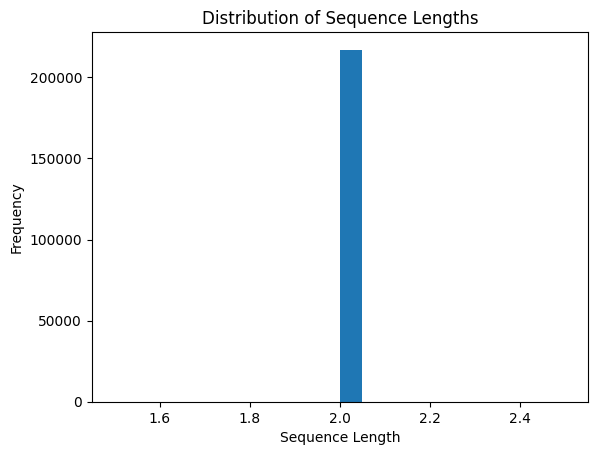

Mean Sequence Length: 2.0
Median Sequence Length: 2.0
Minimum Sequence Length: 2
Maximum Sequence Length: 2
Standard Deviation of Sequence Lengths: 0.0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

dataset = load_data("./code/data-q2/train.txt")
# Assuming dataset is a list of sequences, where each sequence is a list of tokens
# Calculate sequence lengths
sequence_lengths = [len(sequence) for sequence in dataset]

# Visualize the distribution using a histogram
plt.hist(sequence_lengths, bins=20)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

# Compute descriptive statistics
mean_length = np.mean(sequence_lengths)
median_length = np.median(sequence_lengths)
min_length = np.min(sequence_lengths)
max_length = np.max(sequence_lengths)
std_length = np.std(sequence_lengths)

print(f"Mean Sequence Length: {mean_length}")
print(f"Median Sequence Length: {median_length}")
print(f"Minimum Sequence Length: {min_length}")
print(f"Maximum Sequence Length: {max_length}")
print(f"Standard Deviation of Sequence Lengths: {std_length}")


In [75]:
import logging
import random
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from poutyne.framework import Model
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence




# Define embedding_size and hidden_size
embedding_size = 10
hidden_size = 10


# bidirectional
class WordClassifier(nn.Module):
    def __init__(self, vocab, embedding_size, hidden_size, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(len(vocab), embedding_size, padding_idx=0)
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True, bidirectional=True)  # Bidirectional RNN
        self.mapping_layer = nn.Linear(hidden_size * 2, num_classes)  # Multiply hidden size by 2 for bidirectional RNN

    def forward(self, inputs):
        # Inputs: (batch_size, seq_len)
        embedded = self.embedding(inputs)  # Shape: (batch_size, seq_len, embedding_size)

        output, _ = self.rnn(embedded)  # Shape: (batch_size, seq_len, hidden_size * 2) because it's bidirectional

        # Take the last output of the sequence
        last_output = output[:, -1, :]

        logits = self.mapping_layer(last_output)  # Shape: (batch_size, num_classes)
        return logits


class WordClassifierHandlingPadding(WordClassifier):
    def __init__(self, vocab, embedding_size, hidden_size, num_classes):
        super().__init__(vocab, embedding_size, hidden_size, num_classes)

    def forward(self, inputs):
        # If inputs is a tuple, assume it contains sequences and lengths
        if isinstance(inputs, tuple):
            sequences, lengths = inputs
        # If inputs is not a tuple, assume it contains only sequences and compute lengths
        else:
            sequences = inputs
            lengths = torch.count_nonzero(sequences, dim=1).cpu().tolist()

        # Embed the sequences
        embedded = self.embedding(sequences)  # Shape: (batch_size, seq_len, embedding_size)

        # Pack the embedded sequences to handle padding
        packed_embedded = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)

        # Pass the packed sequences through the RNN
        packed_output, _ = self.rnn(packed_embedded)

        # Unpack the packed output
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        # Take the last output of each sequence
        last_output = output[:, -1, :]

        # Pass the last output through the mapping layer
        logits = self.mapping_layer(last_output)  # Shape: (batch_size, num_classes)

        return logits


def vectorize_dataset(dataset, char_to_idx, class_to_idx):
    vectorized_dataset = list()
    for word, lang in dataset:
        label = class_to_idx[lang]
        vectorized_word = list()
        for char in word:
            vectorized_word.append(char_to_idx.get(char, 1))  # Get the char index otherwise set to unknown char
        vectorized_dataset.append((vectorized_word, label))
    return vectorized_dataset


def load_data(filename):
    examples = list()
    with open(filename) as fhandle:
        for line in fhandle:
            examples.append(line[:-1].split())
    return examples


def create_indexes(examples):
    char_to_idx = {"<pad>": 0, "<unk>": 1}
    class_to_idx = {}

    for word, lang in examples:
        if lang not in class_to_idx:
            class_to_idx[lang] = len(class_to_idx)
        for char in word:
            if char not in char_to_idx:
                char_to_idx[char] = len(char_to_idx)
    return char_to_idx, class_to_idx


def make_max_padded_dataset(dataset):
    max_length = max([len(w) for w, l in dataset])
    tensor_dataset = torch.zeros((len(dataset), max_length), dtype=torch.long)
    labels = list()
    for i, (word, label) in enumerate(dataset):
        tensor_dataset[i, :len(word)] = torch.LongTensor(word)
        labels.append(label)
    return tensor_dataset, torch.LongTensor(labels)

import torch

def collate_examples(samples):
    # Get the length of the longest sequence in the batch
    max_len = max(len(word) for word, _ in samples)

    # Initialize lists to store padded sequences and labels
    padded_sequences = []
    labels = []
    # 1: Créez un réseau simple qui prend en entré des exemples de longueur fixes (max length)
    network = WordClassifier(char_to_idx, 10, 10, len(class_to_idx))
    model = Model(network, 'sgd', 'cross_entropy', batch_metrics=['accuracy'])
    model.fit_generator(train_loader, epochs=5)
    loss, acc = model.evaluate_generator(test_loader)
    logging.info("1 - Loss: {}\tAcc:{}".format(loss, acc))

    # 2: Faites en sorte que le padding soit fait "on batch"
    # Le tout devrait se passer dans la fonction collate_examples
    train_loader = DataLoader(vectorized_train, batch_size=128, shuffle=True, collate_fn=collate_examples)
    test_loader = DataLoader(vectorized_test, batch_size=128, collate_fn=collate_examples)
    model = Model(network, 'sgd', 'cross_entropy', batch_metrics=['accuracy'])
    model.fit_generator(train_loader, epochs=5)
    loss, acc = model.evaluate_generator(test_loader)
    logging.info("2 - Loss: {}\tAcc:{}".format(loss, acc))

    # Pad each sequence to have the same length as the longest sequence in the batch
    for word, label in samples:
        # Pad the sequence with the padding token ("<pad>") to match the maximum length
        padded_sequence = torch.tensor(word + [0] * (max_len - len(word)), dtype=torch.long)
        padded_sequences.append(padded_sequence)
        labels.append(label)

    # Convert the lists to PyTorch tensors
    padded_sequences_tensor = torch.stack(padded_sequences)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return padded_sequences_tensor, labels_tensor


def main():
    batch_size = 128
    training_set = load_data("./code/data-q2/train.txt")
    test_set = load_data("./code/data-q2/test.txt")

    char_to_idx, class_to_idx = create_indexes(training_set)

    vectorized_train = vectorize_dataset(training_set, char_to_idx, class_to_idx)
    vectorized_test = vectorize_dataset(test_set, char_to_idx, class_to_idx)

    X_train, y_train = make_max_padded_dataset(vectorized_train)
    X_test, y_test = make_max_padded_dataset(vectorized_test)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # 1: Créez un réseau simple qui prend en entré des exemples de longueur fixes (max length)
    network = WordClassifier(char_to_idx, 10, 10, len(class_to_idx))
    model = Model(network, 'sgd', 'cross_entropy', batch_metrics=['accuracy'])
    model.fit_generator(train_loader, epochs=5)
    loss, acc = model.evaluate_generator(test_loader)
    logging.info("1 - Loss: {}\tAcc:{}".format(loss, acc))

    # 2: Faites en sorte que le padding soit fait "on batch"
    # Le tout devrait se passer dans la fonction collate_examples
    train_loader = DataLoader(vectorized_train, batch_size=128, shuffle=True, collate_fn=collate_examples)
    test_loader = DataLoader(vectorized_test, batch_size=128, collate_fn=collate_examples)
    model = Model(network, 'sgd', 'cross_entropy', batch_metrics=['accuracy'])
    model.fit_generator(train_loader, epochs=5)
    loss, acc = model.evaluate_generator(test_loader)
    logging.info("2 - Loss: {}\tAcc:{}".format(loss, acc))

    # Train WordClassifierHandlingPadding
    network = WordClassifierHandlingPadding(char_to_idx, 10, 10, len(class_to_idx))
    model = Model(network, 'sgd', 'cross_entropy', batch_metrics=['accuracy'])
    model.fit_generator(train_loader, epochs=5)
    loss, acc = model.evaluate_generator(test_loader)
    logging.info("3 - Loss: {}\tAcc:{}".format(loss, acc))



if __name__ == "__main__":
    logging.getLogger().setLevel(logging.INFO)
    np.random.seed(42)
    random.seed(42)
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    main()






Epoch: 1/5 Train steps: 1696 19.91s loss: 2.294531 acc: 12.554144                                
Epoch: 2/5 Train steps: 1696 19.92s loss: 2.290366 acc: 13.035685                                
Epoch: 3/5 Train steps: 1696 19.81s loss: 2.290358 acc: 13.035685                                
Epoch: 4/5 Train steps: 1696 19.21s loss: 2.290369 acc: 13.035685                                
Epoch: 5/5 Train steps: 1696 20.50s loss: 2.290363 acc: 13.035685                                
Test steps: 424 1.73s test_loss: 2.291355 test_acc: 13.044200                                 


INFO:root:1 - Loss: 2.2913547406727623	Acc:13.044199506378764


NameError: name 'char_to_idx' is not defined